In [257]:
import numpy as np
import h5py
import cv2
import glob
import matplotlib.pyplot as plt
import time
import matplotlib.patches as patches

# Evaluation 

In [258]:
def visualise_goal_vs_path(start,goal,poses,legend_pos="upper right"):
    '''
    Visualise the goal path and the path taken
    
    
    '''

    start_x=start[0]
    start_y=start[1]    
    goal_x=goal[0]
    goal_y=goal[1]
    path_x=poses[:,0]
    path_y=poses[:,1]
    fig, ax = plt.subplots()
    circle = patches.Circle((goal_x, goal_y),1.0, edgecolor='orange', facecolor='none', linewidth=2,label="Tolerance (1m)")
    ax.add_patch(circle)
    ax.plot(start_x,start_y,'ro',label="Start")
    ax.plot(goal_x,goal_y,'go',label="Goal")
    ax.plot(path_x,path_y,'-b',label="Path")
    ax.set_xlabel('X coordinate (m)')
    ax.set_ylabel('Y coordinate (m)')
    plt.axis('equal')
    plt.grid()
    plt.title('Goal vs Path Relative to Starting Position')
    plt.legend(loc=legend_pos)
    plt.show()



def visualise_target_vs_iters(acts,goal):
    '''
    Visualise the goal path and the path taken
    
    
    '''
    diff=goal-acts
    squared_difference = np.square(diff)
    squared_sum=np.sum(squared_difference,axis=1)
    sqrt_squared_sum = np.sqrt(squared_sum)
    plt.plot(sqrt_squared_sum,'-b',label="Distance to goal")
    plt.plot(np.ones(sqrt_squared_sum.shape[0]),'--r',label="Tolerance (1m)")
    plt.xlabel('Time (s)')
    plt.ylabel('Absolute distance from goal (m)')
    # plt.axis('equal')
    plt.title('Distance to Goal vs Time')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.show()



def visualise_comaparison(start,goal,expert_traj,agent_traj,legend_pos="upper right"):
    '''
    Comaprea expert and agent traj
    
    '''

    start_x=start[0]
    start_y=start[1]    
    goal_x=goal[0]
    goal_y=goal[1]
    path_x=expert_traj[:,0]
    path_y=expert_traj[:,1]
    path_x_agent=agent_traj[:,0]
    path_y_agent=agent_traj[:,1]
    fig, ax = plt.subplots()
    circle = patches.Circle((goal_x, goal_y),1.0, edgecolor='orange', facecolor='none', linewidth=2,label="Tolerance (1m)")
    ax.add_patch(circle)
    ax.plot(start_x,start_y,'ro',label="Start")
    ax.plot(goal_x,goal_y,'go',label="Goal")
    ax.plot(path_x,path_y,'-b',label="Path of expert")
    ax.plot(path_x_agent,path_y_agent,'-m',label="Path of agent")
    ax.set_xlabel('X coordinate (m)')
    ax.set_ylabel('Y coordinate (m)')
    ax.set_aspect('equal', adjustable='box')
    # ax.axis('equal')
    plt.grid()
    plt.title('Path Taken by Expert vs Agent')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def make_relative(poses,start):
    '''
    Make the poses relative to the start
    
    '''
    poses=poses-start
    return poses

def filter_agent(data,window_size=5):
    '''
    Filter the data using a moving average filter
    
    '''
    return data[:window_size,:]

def find_nearest(actions, goal):
    '''
    Find the nearest value in the array
    
    '''
    difference = actions - goal
    squared_sum = np.sum(np.square(difference), axis=1)
    distances = np.sqrt(squared_sum)
    idx = np.argmin(distances)

   
    return idx
   
    


def read_dataset(file_path):
    '''
    Read the data files from the dataset
    '''
    read_file= h5py.File(file_path, "r")
    batch_size= read_file['kris_dynamics']['odom_data']['target_vector'].shape[0]
    rgbs=[]
    depths=[]
    targets=[]  
    acts=[]
    for i in range(batch_size):
        target=read_file['kris_dynamics']['odom_data']['target_vector'][i]
        rgb=read_file['images']['rgb_data'][i]
        depth=read_file['images']['depth_data'][i]
        act=read_file['kris_dynamics']['odom_data']['odom_data_wheel'][i]    
        ## If visualisation is needed
        # if visualise_img:
        #     visualise(rgb_features,depth_features)  
        rgbs.append(rgb)
        depths.append(depth)
        targets.append(target) 
        acts.append(act)

    acts=np.array(acts[:-1])
    rgbs=np.array(rgbs)
    depths=np.array(depths)
    targets=np.array(targets)

    return acts,targets

In [259]:
# File paths
world='medium_world'
traj='traj1'
expert_file='../GailNavigationNetwork/data/trajectories/expert/'+world+'/'+traj+'.hdf5'
agent_file='../GailNavigationNetwork/data/trajectories/agent/'+world+'/'+traj+'.hdf5'

#Variables of expert
acts_expert,targets_expert=read_dataset(expert_file)
acts_expert=acts_expert[:,:2]
# acts_expert=make_relative(acts_expert,acts_expert[0])
targets_expert=targets_expert[:,:2]
# print(f"acts shape is {acts_expert.shape} first one is {acts_expert[0]} \n shape is {targets_expert.shape} first one is {targets_expert[0]}")
starting_pose=acts_expert[0]
goal_pose=acts_expert[-1]
print(f"Expert demo Starting pose is {starting_pose} and goal_pose is {goal_pose}")
# "{header: {frame_id: 'odom'}, pose: {position: {x: 10.11 , y : 7.51}}}" --once
#Variables of agent

acts_agent,targets_agent=read_dataset(agent_file)
acts_agent=acts_agent[:,:2]
# acts_agent=make_relative(acts_agent,starting_pose)
nearest_goal=find_nearest(acts_agent,goal_pose)
acts_agent=filter_agent(acts_agent,nearest_goal)
targets_agent=targets_agent[:,:2]
print(f"acts shape is {acts_agent.shape} first one is {acts_agent[0]} \n shape is {targets_agent.shape} first one is {targets_agent[0]}")


Expert demo Starting pose is [-8.64257709 -4.18662929] and goal_pose is [-9.79619096 10.44728482]
acts shape is (286, 2) first one is [-8.86099955 -4.56950345] 
 shape is (296, 2) first one is [-0.92900045 -5.22049655]


In [260]:
# visualise_goal_vs_path(starting_pose,goal_pose,acts_expert,"upper left")

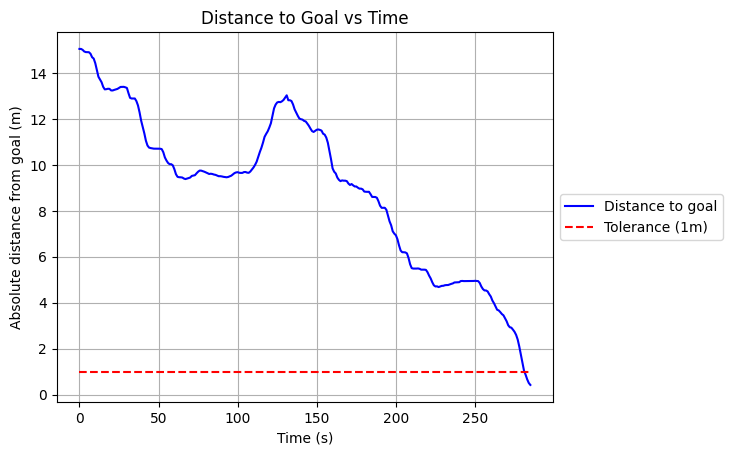

In [261]:
visualise_target_vs_iters(acts_agent,goal_pose)

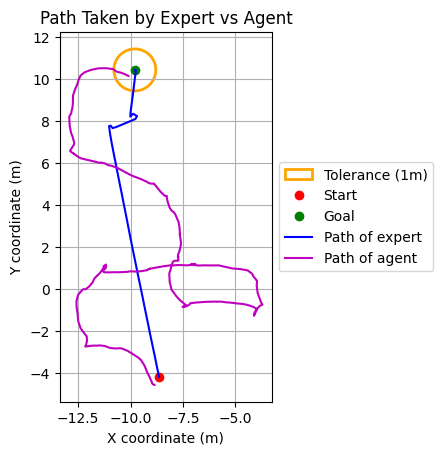

In [262]:
visualise_comaparison(starting_pose,goal_pose,acts_expert,acts_agent,"upper left")